In [158]:
import os
import pandas as pd
from PIL.Image import open
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import cophenet, cut_tree
import matplotlib.pyplot as plt
import warnings
%config InlineBackend.figure_format = 'retina'
plt.style.use('bmh')
warnings.filterwarnings('ignore')

# 1.

Apply 𝑘-means and hierarchical clustering to the ORL face dataset. Set 𝑘 = 2 in 𝑘-means and select 2 clusters in hierarchical clustering. Do the clustering results match the two genders?


In [159]:
try:
    path_ = os.getcwd()+'/ORL Faces'
except:
    print('Set path_ to your ORL Faces fold directory')

df = pd.DataFrame()

for people in range(1, 41):
    for order in range(1, 11):
        im = open(path_+'/'+str(people)+'_'+str(order)+'.png')
        ar = pd.DataFrame(np.mat(np.asarray(im).flatten()), columns=[
                          r for r in range(1, 2577)], index=[(people-1)*10+order-1])
        df = pd.concat([df, ar], axis=0)
# add target columns
gender = [0]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [0]*10 + [1]*10 + [0]*10 + \
    [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10+[1]*10 + [1]*10 + \
    [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1] * 10 + \
    [1]*10 + [0]*10 + [1]*10 + [1]*10 + [1] * 10 + \
    [1]*10 + [1]*10 + [1]*10 + [1]*10 + [1]*10
df['gender'] = gender
df


,1,2,3,4,5,6,7,8,9,10,...,2568,2569,2570,2571,2572,2573,2574,2575,2576,gender
0,88,88,90,91,91,92,90,93,99,109,...,176,166,149,142,145,141,138,142,134,0
1,87,90,95,96,92,90,97,107,111,112,...,175,172,147,131,132,124,124,120,88,0
2,92,92,88,98,104,109,108,100,80,63,...,84,128,154,161,169,170,165,146,151,0
3,92,96,93,94,99,105,108,109,121,152,...,153,164,163,165,166,161,157,79,54,0
4,83,75,88,91,101,90,86,80,63,58,...,145,148,151,139,134,173,167,176,188,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,124,124,125,123,124,125,123,124,123,122,...,34,63,37,37,37,38,39,38,40,1
396,128,128,128,128,129,128,129,127,127,127,...,92,90,90,91,91,91,91,92,93,1
397,122,123,124,124,123,123,122,126,130,126,...,24,57,41,37,36,37,38,40,38,1
398,120,119,121,119,120,121,122,117,111,100,...,137,134,101,26,77,95,95,92,90,1


## kmeans


In [160]:
X = df.drop(['gender'], axis=1)
y = df['gender']

# Compute k-means clustering
kmeans_results = KMeans(n_clusters=2, random_state=322).fit(X)

# Create a dataframe with cluster labels
data_with_label = pd.DataFrame(df)
data_with_label['cluster'] = kmeans_results.labels_

# Create a table of cluster labels by gender
table = pd.crosstab(
    index=data_with_label['gender'], columns=data_with_label['cluster'])
display(table)

kmeans_accuarcy = (table.iloc[0, 0] + table.iloc[1, 1]) / len(data_with_label)
print(f'{kmeans_accuarcy=}')

cluster,0,1
gender,,
0,30,10
1,188,172


kmeans_accuarcy=0.505


## hierarchical clustering


col_0,0,1
gender,,
0,31,9
1,350,10


The accuracy of hierarchical clustering is 0.1025


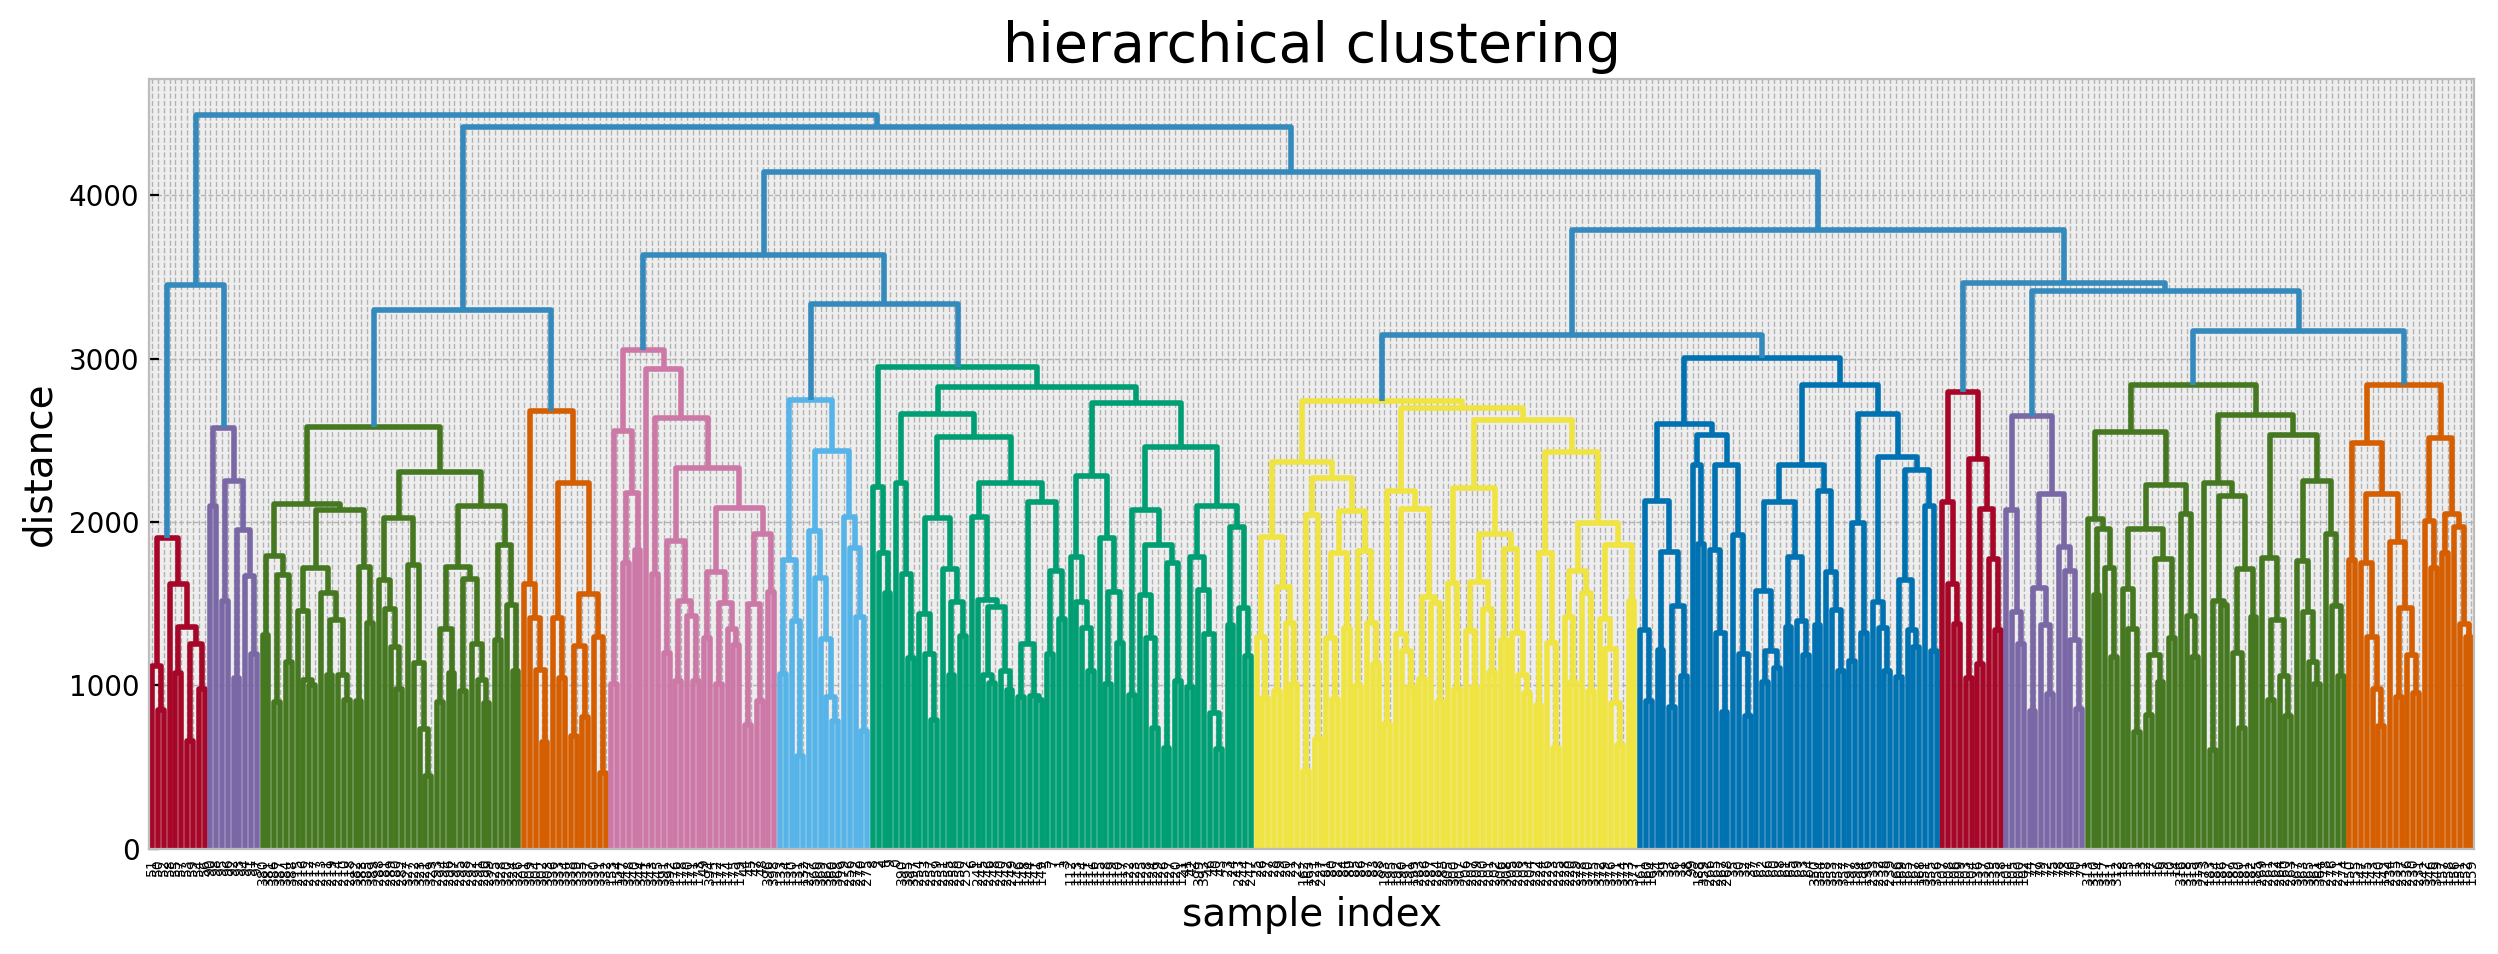

In [161]:
# Create a distance matrix
dist_matrix = pdist(X)

# Compute hierarchical clustering
hclust_result = linkage(dist_matrix, method='complete')

# Plot the dendrogram
plt.figure(figsize=(15, 5))
plt.title('hierarchical clustering', fontsize=20)
plt.xlabel('sample index', fontsize=14)
plt.ylabel('distance', fontsize=14)
dendrogram(hclust_result, leaf_rotation=90.)

# Compute cluster labels
clusters = cut_tree(hclust_result, n_clusters=2)

# Create a table of cluster labels by gender
table = pd.crosstab(
    index=data_with_label['gender'], columns=clusters.reshape(-1))
display(table)

# Compute hierarchical clustering accuracy
hclust_acc = (table.iloc[0, 0] + table.iloc[1, 1]) / len(data_with_label)

# Print the results
print("The accuracy of hierarchical clustering is " + str(hclust_acc))

## Conclusion 
從結果可以看得出來兩個結果都不好，accuracy:

- k-means: 0.505
- hierarchical clustering: 0.1025

從 hierarchical clustering 的圖上可以觀察到在這筆資料集可以分成很多類，若硬分成兩類會導致其中一個類別的資料數很少，導致他的準確率很低


# 2.

Drop the “origin” variable from AutoMPG and apply 𝑘-means, hierarchical clustering, and DBSCAN to the modified AutoMPG. Do the clustering results match the origin? Compare and discuss the results with those from the supervised learning methods done in HW#07-EX3.


In [162]:
cols = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
        'acceleration', 'model year', 'origin', 'car name']
autompg = pd.read_csv('auto-mpg.data.txt', sep='\s+', header=None, names=cols)
autompg = autompg.loc[autompg['horsepower'] != '?']
display(autompg, autompg['origin'].unique())

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.00,2790.0,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.00,2130.0,24.6,82,2,vw pickup
395,32.0,4,135.0,84.00,2295.0,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.00,2625.0,18.6,82,1,ford ranger


array([1, 3, 2])

## kmeans


In [163]:

autompg_filter = autompg.drop(['car name', 'origin'], axis=1).astype(float)
kmeans_results = KMeans(n_clusters=3, random_state=322).fit(autompg_filter)

x_labels = autompg[['mpg', 'origin']]
x_labels['cluster'] = kmeans_results.labels_

table = pd.crosstab(index=x_labels['origin'], columns=x_labels['cluster'])
display(table)

kmeans_accuarcy2 = 0
for i in range(len(table)):
    kmeans_accuarcy2 += table.iloc[i, i]

kmeans_accuarcy2 /= autompg.shape[0]
print(f'{kmeans_accuarcy2=}')

cluster,0,1,2
origin,,,
1,96,89,60
2,17,1,50
3,9,0,70


kmeans_accuarcy2=0.4260204081632653


## hierarchical clustering


col_0,0,1,2
origin,,,
1,112,92,41
2,23,1,44
3,13,0,66


The accuracy of hierarchical clustering is 0.45663265306122447


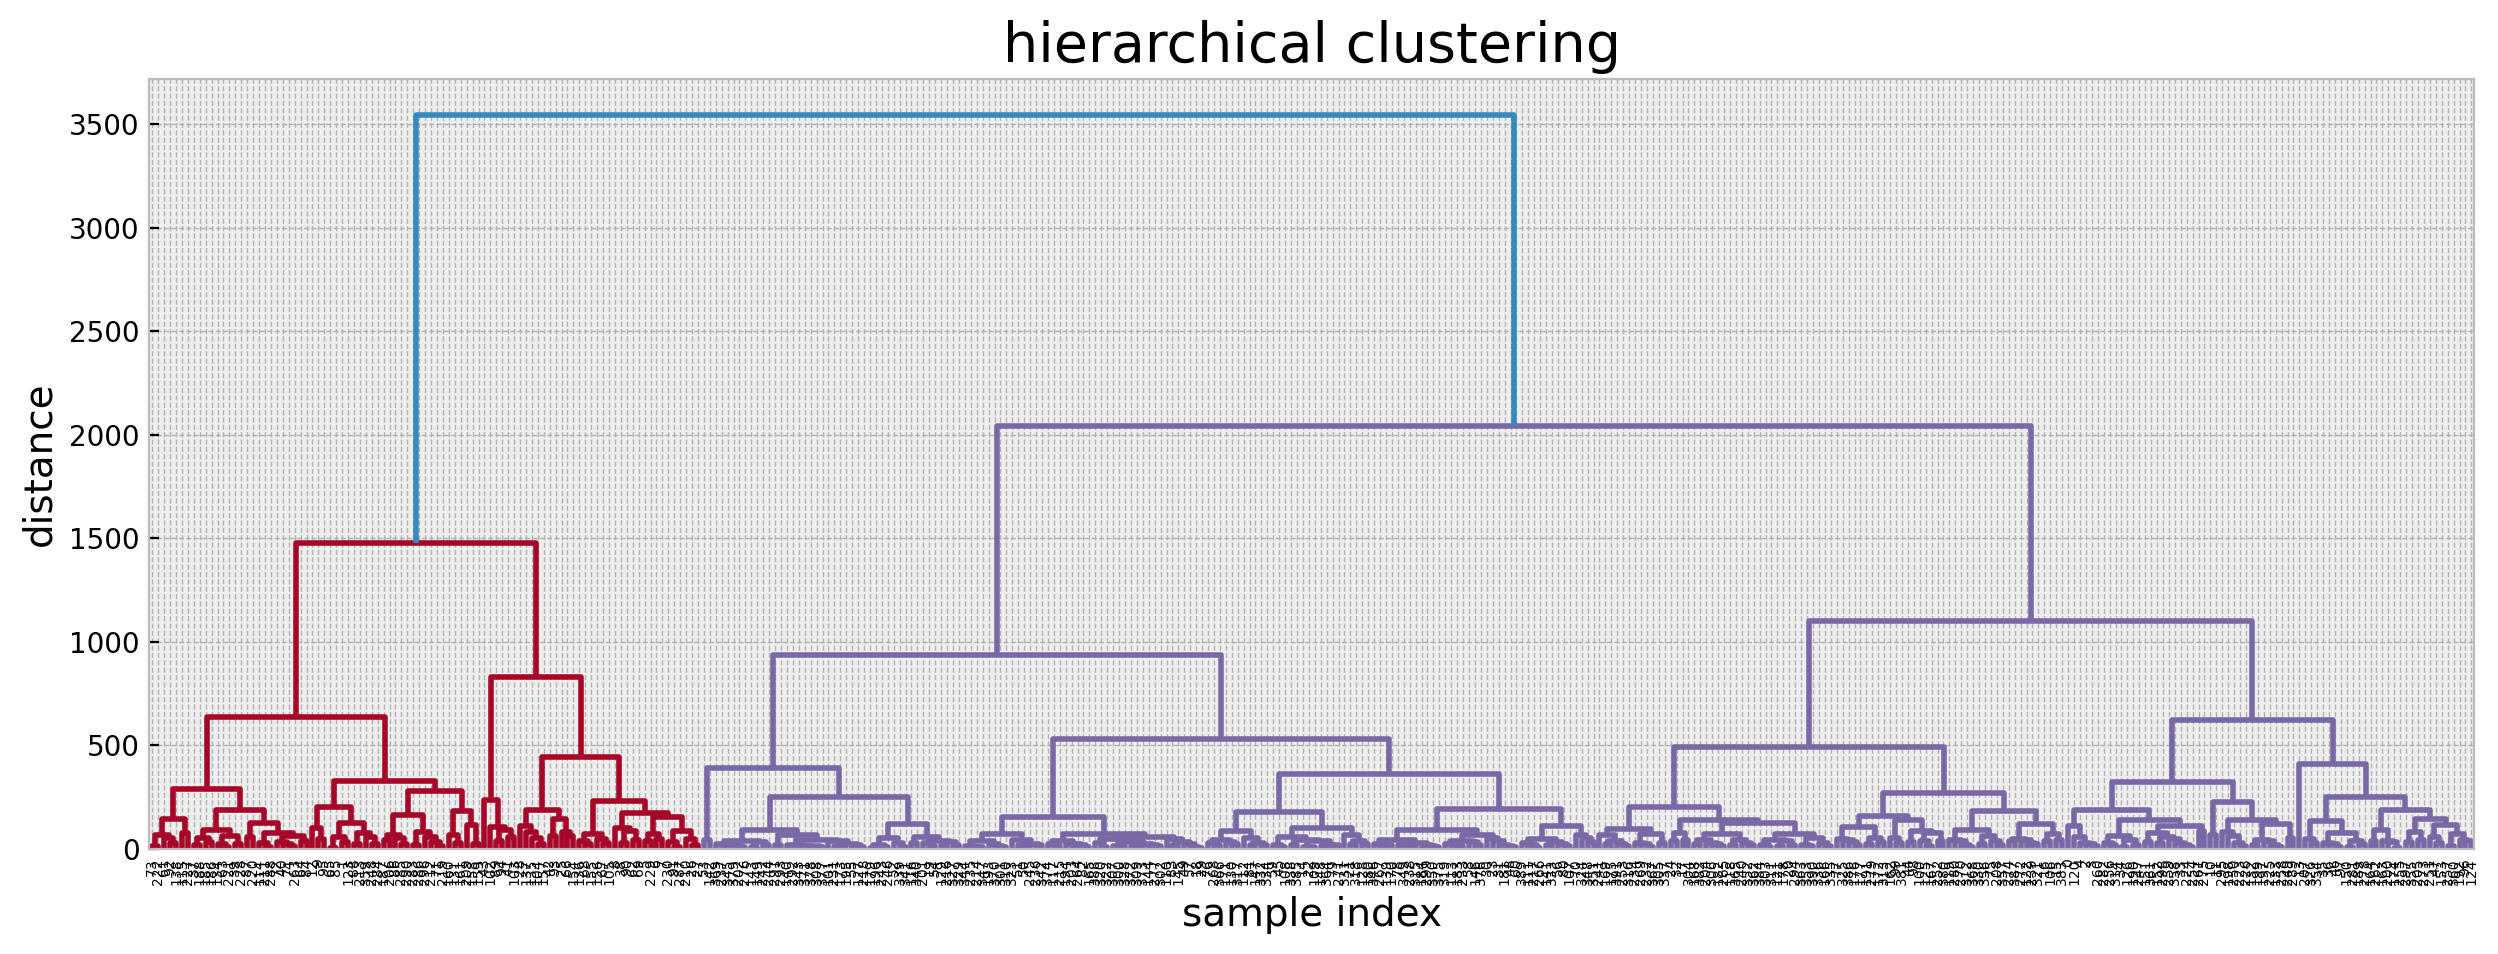

In [164]:
# Create a distance matrix
dist_matrix = pdist(autompg_filter)

# Compute hierarchical clustering
hclust_result = linkage(dist_matrix, method='complete')

# Plot the dendrogram
plt.figure(figsize=(15, 5))
plt.title('hierarchical clustering', fontsize=20)
plt.xlabel('sample index', fontsize=14)
plt.ylabel('distance', fontsize=14)
dendrogram(hclust_result, leaf_rotation=90.)

# Compute cluster labels
clusters = cut_tree(hclust_result, n_clusters=3)

# Create a table of cluster labels by gender
table = pd.crosstab(index=autompg['origin'], columns=clusters.reshape(-1))
display(table)

# Compute hierarchical clustering accuracy
hclust_acc = (table.iloc[0, 0] + table.iloc[1, 1] +
              table.iloc[2, 2]) / (autompg.shape[0])

# Print the results
print("The accuracy of hierarchical clustering is " + str(hclust_acc))

## DBSCAN


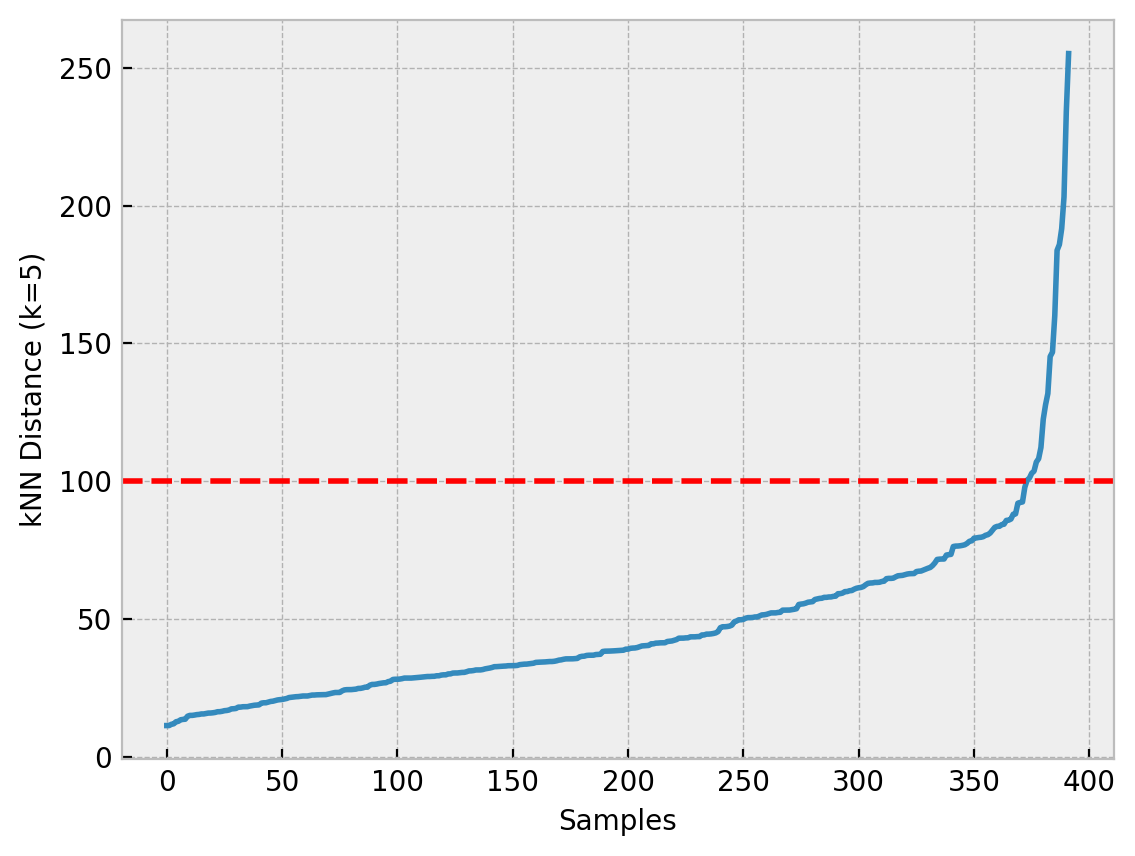

In [165]:
from sklearn.neighbors import NearestNeighbors

# Convert data to a matrix
data = np.array(autompg_filter)

# Compute kNN distances
knn = NearestNeighbors(n_neighbors=6).fit(data)
distances, indices = knn.kneighbors(data)
distances=np.sort(distances,axis=0)
distances=distances[:,5]
# Plot the kNN distances
plt.plot(distances)
plt.xlabel('Samples')
plt.ylabel('kNN Distance (k=5)')
plt.axhline(y=100, color='red', linestyle='--')
plt.show()

### reference
If your data has more than 2 dimensions, choose MinPts = 2*dim, where dim= the dimensions of your data set (Sander et al., 1998).

So, i choose MinPts=14

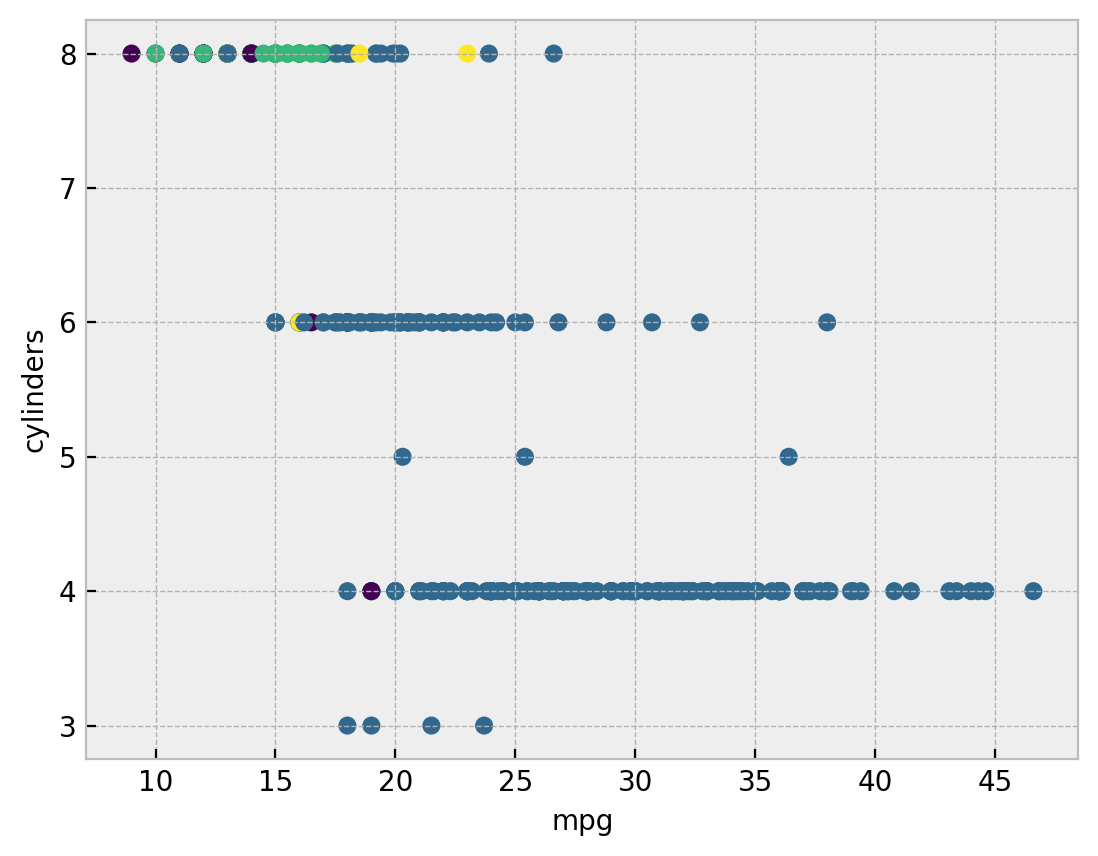

cluster,-1,0,1,2
origin,,,,
1,20,166,51,8
2,2,66,0,0
3,2,77,0,0


dbscan_acc=0.42346938775510207


In [166]:
from sklearn.cluster import DBSCAN


dbscan_result = DBSCAN(eps=100, min_samples=14).fit(data)
plt.scatter(data[:, 0], data[:, 1], c=dbscan_result.labels_)
plt.xlabel('mpg')
plt.ylabel('cylinders')
plt.show()

# Create a dataframe with cluster labels
x_labels = autompg[['origin']]  # Select columns with "origin" and "mpg"
x_labels['cluster'] = dbscan_result.labels_

# Create a table of cluster labels by origin
table = pd.crosstab(index=x_labels['origin'], columns=x_labels['cluster'])
display(table)

dbscan_acc=0
for i in range(3):
    dbscan_acc+=table.iloc[i,i+1]
    
dbscan_acc/=len(autompg)

print(f'{dbscan_acc=}')


## Conclusion
上面三個分類結果accuracy分別為：
- k-means: 0.4260
- hierarchical clustering: 0.4566
- DBSCAN: 0.4235
在這個資料集中三個表現都不好

與作業7-3做對比後，可以發現於作業三的結果比較好了一點

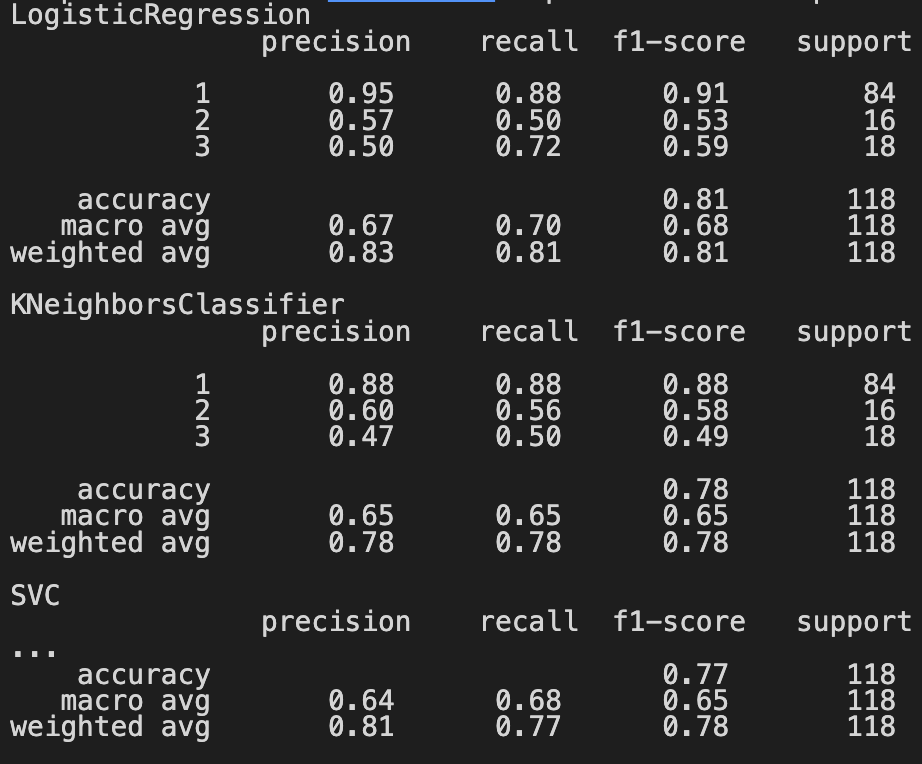

In [168]:
open('image.png')